In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# General setup for GPU device and default tensor type.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import sys
sys.path.append("/home/stella/anaconda3/envs/nerf/lib/python3.7/site-packages")

In [3]:
from functools import partial
import jax # jax==0.1.67 / jaxlib==0.1.55
from jax import random, grad, jit, vmap, flatten_util, nn
from jax.experimental import optix
from jax.config import config
import jax.numpy as np

import haiku as hk

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import cv2

import imageio
import json
import pickle
from time import time
import glob

rng = jax.random.PRNGKey(42)

In [4]:
DATASET = 'sacre'
posedir = f'/mnt/hdd1/stella/inerf/learnit_Data/phototourism/sacre/' # Directory condtains [bds.npy, c2w_mats.npy, kinv_mats.npy, res_mats.npy]
imgdir = f'/mnt/hdd1/stella/inerf/learnit_Data/phototourism/original/sacre/sacre_coeur/dense/images/' # Directory of images

posedata = {}
for f in os.listdir(posedir):
    if '.npy' not in f:
        continue
    z = np.load(os.path.join(posedir, f))
    posedata[f.split('.')[0]] = z
print('Pose data loaded - ', posedata.keys())

imgfiles = sorted(glob.glob(imgdir + '/*.jpg'))
print(f'{len(imgfiles)} images')

Pose data loaded -  dict_keys(['kinv_mats', 'bds', 'c2w_mats', 'res_mats'])
1179 images


In [5]:
def get_example(img_idx, split='train', downsample=4):
    sc = .05
    if 'train' in split:
        img_idx + 25
    if 'val' in split:
        img_idx + 20
    img = imageio.imread(imgfiles[img_idx])[...,:3]/255.
    c2w = posedata['c2w_mats'][img_idx]
    kinv = posedata['kinv_mats'][img_idx]
    c2w = np.concatenate([c2w[:3,:3], c2w[:3,3:4]*sc], -1)
    bds = posedata['bds'][img_idx] * np.array([.9, 1.2]) * sc
    H, W = img.shape[:2]
    i, j = np.meshgrid(np.arange(0,W,downsample), np.arange(0,H,downsample), indexing='xy')
    
    test_images = img[j, i]
    test_rays = get_rays_(c2w, kinv, i, j)
    return test_images, test_rays, bds

# NeRF Renderer and Model

In [6]:
def render_rays(rnd_input, model, params, bvals, rays, near, far, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = np.reshape(pts, [-1,3])
    if bvals is not None:
        pts_flat = np.concatenate([np.sin(pts_flat @ bvals.T), 
                                np.cos(pts_flat @ bvals.T)], axis=-1)
        
    raw = model.apply(params, pts_flat)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1. - np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1. - alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2) 
    acc_map = np.sum(weights, -1)
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(rnd_input, model, params, bvals, rays, near, far, rand, allret, N_samples):
    return render_rays(rnd_input, model, params, bvals, rays, near, far, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 7, 8, 9))

def render_fn(rnd_input, model, params, bvals, rays, near, far, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(rnd_input, model, params, bvals, rays[:,i:i+chunk], near, far, rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [7]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.width = 256
        self.depth = 6
        self.use_viewdirs = False
                
    def __call__(self, coords, view_dirs=None):
        sh = coords.shape
        if self.use_viewdirs:
            viewdirs = None
            viewdirs = np.repeat(viewdirs[...,None,:], coords.shape[-2], axis=-2)
            viewdirs /= np.linalg.norm(viewdirs, axis=-1, keepdims=True)
            viewdirs = np.reshape(viewdirs, (-1,3))
            viewdirs = hk.Linear(output_size=self.width//2)(viewdirs)
            viewdirs = jax.nn.relu(viewdirs)
        coords = np.reshape(coords, [-1,3])
        
        x = np.concatenate([np.concatenate([np.sin(coords*(2**i)), np.cos(coords*(2**i))], axis=-1) for i in np.linspace(0,8,20)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        if self.use_viewdirs:
            density = hk.Linear(output_size=1)(x)
            x = np.concatenate([x,viewdirs], axis=-1)
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            rgb = hk.Linear(output_size=3)(x)
            out = np.concatenate([density, rgb], axis=-1)
        else:
            out = hk.Linear(output_size=4)(x)
        out = np.reshape(out, list(sh[:-1]) + [4])
        return out

In [8]:
@jit
def get_rays_(c2w, kinv, i, j):
#     i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    pixco = np.stack([i, j, np.ones_like(i)], -1)
    dirs = pixco @ kinv.T
#     dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

def normalize(x):
    return x / np.linalg.norm(x)
def viewmatrix(z, up, pos):
    vec2 = normalize(z)
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m
def ptstocam(pts, c2w):
    tt = np.matmul(c2w[:3,:3].T, (pts-c2w[:3,3])[...,np.newaxis])[...,0]
    return tt
def poses_avg(poses):
    center = poses[:, :3, 3].mean(0)
    vec2 = normalize(poses[:, :3, 2].sum(0))
    up = poses[:, :3, 1].sum(0)
    return viewmatrix(vec2, up, center)
def render_path_spiral(c2w, up, rads, focal, zrate, rots, N):
    render_poses = []
    rads = np.array(list(rads) + [1.])
    for theta in np.linspace(0., 2. * np.pi * rots, N+1)[:-1]:
        c = np.dot(c2w[:3,:4], np.array([np.cos(theta), -np.sin(theta), -np.sin(theta*zrate), 1.]) * rads) 
        z = normalize(c - np.dot(c2w[:3,:4], np.array([0,0,-focal, 1.])))
        render_poses.append(viewmatrix(z, up, c))
    return render_poses


In [9]:
batch_size = 64
N_samples = 128
inner_step_size = 1

model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

@jit
def single_step(rng, image, rays, params, bds):
    def sgd(param, update):
        return param - inner_step_size * update
    
    rng, rng_inputs = jax.random.split(rng)
    def loss_model(params):
        g = render_rays(rng_inputs, model, params, None, rays, bds[0], bds[1], N_samples, rand=True)
        return mse_fn(g, image)
    
    model_loss, grad = jax.value_and_grad(loss_model)(params)
    new_params = jax.tree_multimap(sgd, params, grad)
    return rng, new_params, model_loss

def update_network_weights(rng, images, rays, params, inner_steps, bds):
    for _ in range(inner_steps):
        rng, rng_input = random.split(rng)
        idx = random.randint(rng_input, shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]
        
        rng, params, loss = single_step(rng, image_sub, rays_sub, params, bds)
    return rng, params, loss

# Meta Train

In [10]:
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

In [11]:
"""
max_iters = 150000

inner_update_steps = 64
lr = 5e-4

exp_name = f'{DATASET}_ius_{inner_update_steps}_ilr_{inner_step_size}_olr_{lr}_bs_{batch_size}'
exp_dir = f'checkpoint/phototourism_checkpoints/{exp_name}/'

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

params = model.init(rng, np.ones((1,3)))

opt = optix.adam(lr)
opt_state = opt.init(params)

test_inner_steps = 64


def update_model(rng, params, opt_state, image, rays, bds):
    rng, new_params, model_loss = update_network_weights(rng, image, rays, params, inner_update_steps, bds)
    
    def calc_grad(params, new_params):
        return params - new_params
    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss

@jit
def update_model_single(rng, params, opt_state, image, rays, bds):
    rng, new_params, model_loss = single_step(rng, image, rays, params, bds)
    
    def calc_grad(params, new_params):
        return params - new_params
    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss



plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0

train_psnrs = []
rng = jax.random.PRNGKey(0)

train_steps = []
train_psnrs_all = []
test_steps = []
test_psnrs_all = []
for step in tqdm(range(max_iters)):
    try:
        rng, rng_input = jax.random.split(rng)
        img_idx = random.randint(rng_input, shape=(), minval=0, maxval=len(imgfiles)-25)        
        images, rays, bds = get_example(img_idx, downsample=1)
    except:
        print('data loading error')
        raise
        continue
        

    images = np.reshape(images, (-1,3))
    rays = np.reshape(rays, (2,-1,3))

    if inner_update_steps == 1:
        rng, rng_input = random.split(rng)
        idx = random.randint(rng_input, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, opt_state, loss = update_model_single(rng, params, opt_state, images[idx,:], rays[:,idx,:], bds)
    else:
        rng, params, opt_state, loss = update_model(rng, params, opt_state, images, rays, bds)
    train_psnrs.append(-10 * np.log10(loss))

    if step % 250 == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_steps.append(step)
        train_psnrs_all.append(np.mean(np.array(train_psnrs)))
        train_psnrs = []
    if step % 500 == 0 and step != 0:
        test_psnr = []
        for ti in range(5):
            test_images, test_rays, bds = get_example(ti, split='val', downsample=2)

            test_images, test_holdout_images = np.split(test_images, [test_images.shape[1]//2], axis=1)
            test_rays, test_holdout_rays = np.split(test_rays, [test_rays.shape[2]//2], axis=2)

            test_images_flat = np.reshape(test_images, (-1,3))
            test_rays = np.reshape(test_rays, (2,-1,3))

            rng, test_params, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, test_inner_steps, bds)

            test_result = np.clip(render_fn(rng, model, test_params, None, test_holdout_rays, bds[0], bds[1], N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_holdout_images, test_result))
        test_psnr = np.mean(np.array(test_psnr))

        test_steps.append(step)
        test_psnrs_all.append(test_psnr)
        
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15,5))   
        plt.subplot(1,3, 1)
        plt.imshow(test_images)
        plt.subplot(1,3, 2)
        plt.imshow(test_holdout_images)
        plt.subplot(1,3, 3)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        test_images, test_rays, bds = get_example(0, split='test')
        test_images_flat = np.reshape(test_images, (-1,3))
        test_rays = np.reshape(test_rays, (2,-1,3))
        rng, test_params_1, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, test_inner_steps, bds)

        test_images, test_rays, bds = get_example(1, split='test')
        test_images_flat = np.reshape(test_images, (-1,3))
        test_rays = np.reshape(test_rays, (2,-1,3))
        rng, test_params_2, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, test_inner_steps, bds)
        
        poses = posedata['c2w_mats']
        c2w = poses_avg(poses)
        focal = .8
        render_poses = render_path_spiral(c2w, c2w[:3,1], [.1, .1, .05], focal, zrate=.5, rots=2, N=120)
        
        bds = np.array([5., 25.]) * .05
        H = 128
        W = H*3//2
        f = H * 1.
        kinv = np.array([
            1./f, 0, -W*.5/f,
            0, -1./f, H*.5/f,
            0, 0, -1.
        ]).reshape([3,3])
        i, j = np.meshgrid(np.arange(0,W), np.arange(0,H), indexing='xy')
        renders = []
        for p, c2w in enumerate(tqdm(render_poses)):
            rays = get_rays_(c2w, kinv, i, j)
            interp = p / len(render_poses)
            interp_params = jax.tree_multimap(lambda x, y: y*p/len(render_poses) + x*(1-p/len(render_poses)), test_params_1, test_params_2)
            result = render_fn(rng, model, interp_params, None, rays, bds[0], bds[1], N_samples, rand=False)[0]
            renders.append(result)
        
        renders = (np.clip(np.array(renders), 0, 1)*255).astype(np.uint8)
        imageio.mimwrite(f'{exp_dir}render_sprial_{step}.mp4', renders, fps=30, quality=8)
        
        plt.plot(train_steps, train_psnrs_all)
        plt.savefig(f'{exp_dir}train_curve_{step}.png')
        
        plt.plot(test_steps, test_psnrs_all)
        plt.savefig(f'{exp_dir}test_curve_{step}.png')
        
        with open(f'{exp_dir}checkpount_{step}.pkl', 'wb') as file:
            pickle.dump(params, file)
"""

"\nmax_iters = 150000\n\ninner_update_steps = 64\nlr = 5e-4\n\nexp_name = f'{DATASET}_ius_{inner_update_steps}_ilr_{inner_step_size}_olr_{lr}_bs_{batch_size}'\nexp_dir = f'checkpoint/phototourism_checkpoints/{exp_name}/'\n\nif not os.path.exists(exp_dir):\n    os.makedirs(exp_dir)\n\nparams = model.init(rng, np.ones((1,3)))\n\nopt = optix.adam(lr)\nopt_state = opt.init(params)\n\ntest_inner_steps = 64\n\n\ndef update_model(rng, params, opt_state, image, rays, bds):\n    rng, new_params, model_loss = update_network_weights(rng, image, rays, params, inner_update_steps, bds)\n    \n    def calc_grad(params, new_params):\n        return params - new_params\n    model_grad = jax.tree_multimap(calc_grad, params, new_params)\n    \n    updates, opt_state = opt.update(model_grad, opt_state)\n    params = optix.apply_updates(params, updates)\n    return rng, params, opt_state, model_loss\n\n@jit\ndef update_model_single(rng, params, opt_state, image, rays, bds):\n    rng, new_params, model_loss

# Test-time optimization

### Load checkpoint (optional)

In [12]:
checkpoint_file = 'checkpoints/Phototourism/sacre_checkpount_150000.pkl'

with open(checkpoint_file, 'rb') as file:
    params = pickle.load(file)

## iNeRF + Testset Adaptation

In [13]:
"""
import pprint
from time import time
from tqdm import tqdm, trange
from run_nerf_helpers import *

import matplotlib.pyplot as plt
import jax.numpy as jnp
import run_nerf

torch.set_default_tensor_type('torch.cuda.DoubleTensor')
"""

"\nimport pprint\nfrom time import time\nfrom tqdm import tqdm, trange\nfrom run_nerf_helpers import *\n\nimport matplotlib.pyplot as plt\nimport jax.numpy as jnp\nimport run_nerf\n\ntorch.set_default_tensor_type('torch.cuda.DoubleTensor')\n"

In [14]:
"""
# render NeRF network at Target view 

poses = posedata['c2w_mats']
init_index = 0
initpose = torch.tensor(poses[init_index]).to(device)
# learn_trans = torch.cat((torch.zeros(6).to(device).requires_grad_(True), torch.ones(1).to(device).requires_grad_(True))) # w(3), v(3)
learn_rot = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)
learn_trl = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)
theta = torch.ones(1).to(device).requires_grad_(True) # w(3), v(3)
learn_trans = torch.cat((learn_rot, learn_trl, theta)).to(device)
learn_trans = torch.tensor(learn_trans)

def get_translated_pose(initpose, learn_trans): # 4x4, 1x6

    if 1:
        w = torch.zeros(3,3).to(learn_trans.device)
        theta = learn_trans[6]
        wnorm = 1 if torch.norm(learn_trans[0:3])==0 else torch.norm(learn_trans[0:3])
        w[0,1] = -learn_trans[2]/wnorm
        w[1,0] = learn_trans[2]/wnorm
        w[0,2] = learn_trans[1]/wnorm
        w[2,0] = -learn_trans[1]/wnorm
        w[1,2] = -learn_trans[0]/wnorm
        w[2,1] = learn_trans[0]/wnorm
        R = torch.matrix_exp(w*theta) # ^c1_c2{R}

        v = learn_trans[3:6].reshape(3,1)
        transform_pose = torch.zeros(4, 4).to(learn_trans.device)
        transform_pose[0:3,0:3] = R
        print(w.get_device())
        mat1 = (torch.eye(3) * theta) - (1 - torch.cos(theta) * w) + ((theta - torch.sin(theta)) * torch.matmul(w, w))
        mat2 = torch.matmul(mat1, v).squeeze()
        transform_pose[0:3,-1] = mat2
        transform_pose[3,3] = 1
        newpose = torch.matmul(transform_pose, initpose)

    return newpose

with torch.no_grad():
    print("init: \n", initpose)
    
    newpose = get_translated_pose(initpose, learn_trans)
    print(newpose)
    print(torch.equal(newpose, initpose))
    """

'\n# render NeRF network at Target view \n\nposes = posedata[\'c2w_mats\']\ninit_index = 0\ninitpose = torch.tensor(poses[init_index]).to(device)\n# learn_trans = torch.cat((torch.zeros(6).to(device).requires_grad_(True), torch.ones(1).to(device).requires_grad_(True))) # w(3), v(3)\nlearn_rot = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)\nlearn_trl = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)\ntheta = torch.ones(1).to(device).requires_grad_(True) # w(3), v(3)\nlearn_trans = torch.cat((learn_rot, learn_trl, theta)).to(device)\nlearn_trans = torch.tensor(learn_trans)\n\ndef get_translated_pose(initpose, learn_trans): # 4x4, 1x6\n\n    if 1:\n        w = torch.zeros(3,3).to(learn_trans.device)\n        theta = learn_trans[6]\n        wnorm = 1 if torch.norm(learn_trans[0:3])==0 else torch.norm(learn_trans[0:3])\n        w[0,1] = -learn_trans[2]/wnorm\n        w[1,0] = learn_trans[2]/wnorm\n        w[0,2] = learn_trans[1]/wnorm\n        w[2,0] = -learn_tran

# Make Keyframe
# 내생각에는 들어온 카메라 정보로 렌더링해서 만드는게 좋을거 같다. 

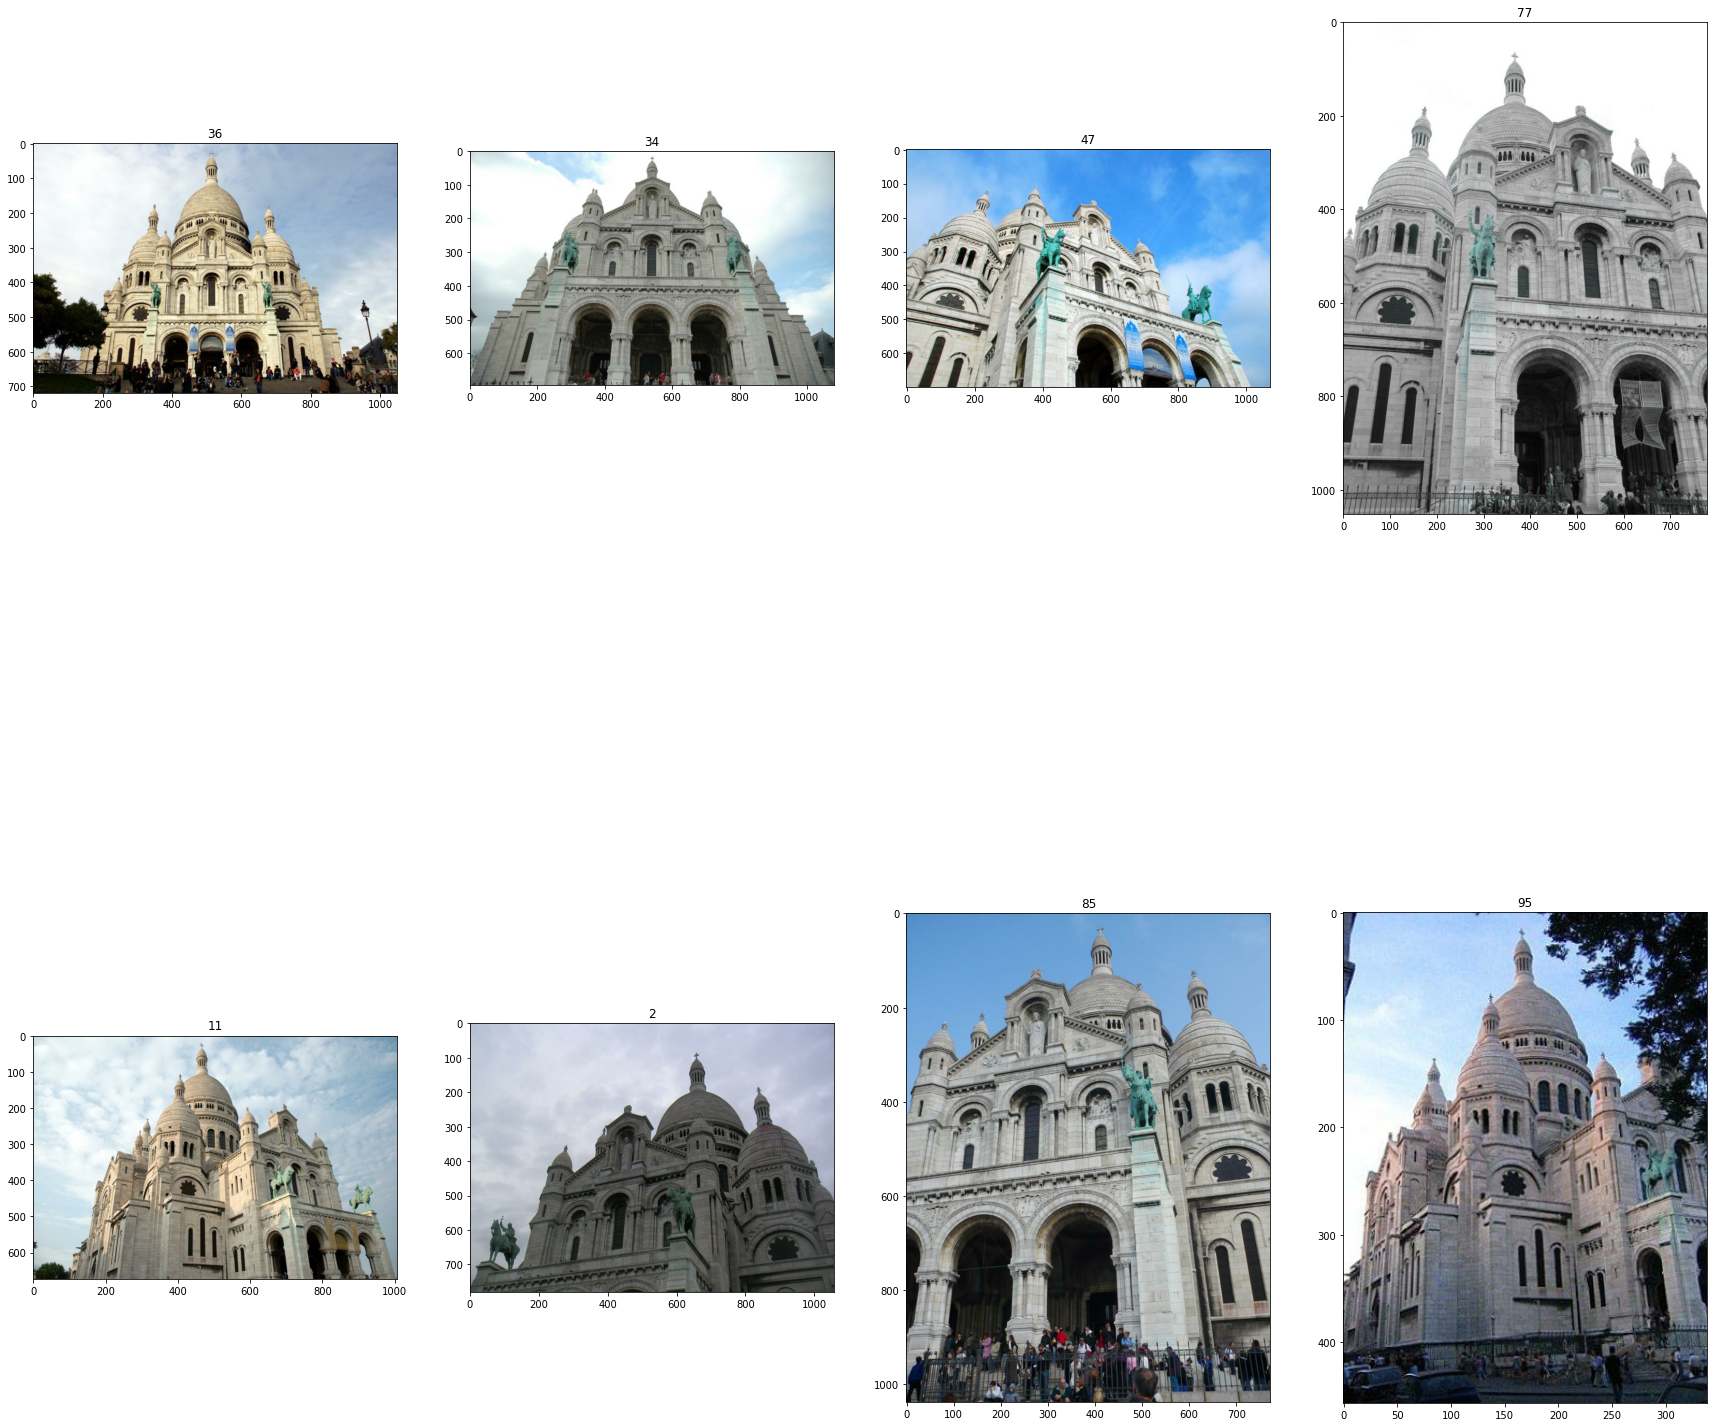

In [15]:
import matplotlib.pyplot as plt
import imageio
downsample = 2
ius = 256
views = range(100)
views = [36, 34, 47, 77, 11, 2, 85, 95]
plt.figure(figsize=(30,30))
num =1
for s in views:
    img = imageio.imread(imgfiles[s-1])[...,:3]/255.
    #print(s)
    plt.subplot(2,4, num)
    plt.title(s)
    plt.imshow(img)
    num = num +1
plt.show()

# Pose estimation

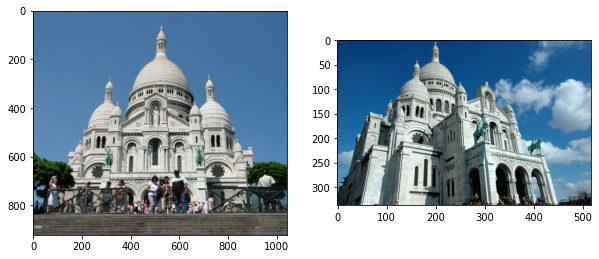

In [16]:
# show ground truth target pose and image
poses = posedata['c2w_mats']
init_index = 1000 # 63
target_index = 95 # 70
Targetpose = poses[target_index]
Targetrgb = (imageio.imread(imgfiles[target_index])[...,:3])/255
initrgb = imageio.imread(imgfiles[init_index])/255

fig1 = plt.figure(figsize=(10,10))
axes1 = fig1.subplots(nrows=1, ncols=2)
axes1[0].imshow(initrgb)
axes1[1].imshow(Targetrgb)

Targetrgb = torch.tensor(Targetrgb, dtype=torch.float32).to(device)
Targetpose = torch.tensor(Targetpose, dtype=torch.float32).to(device)

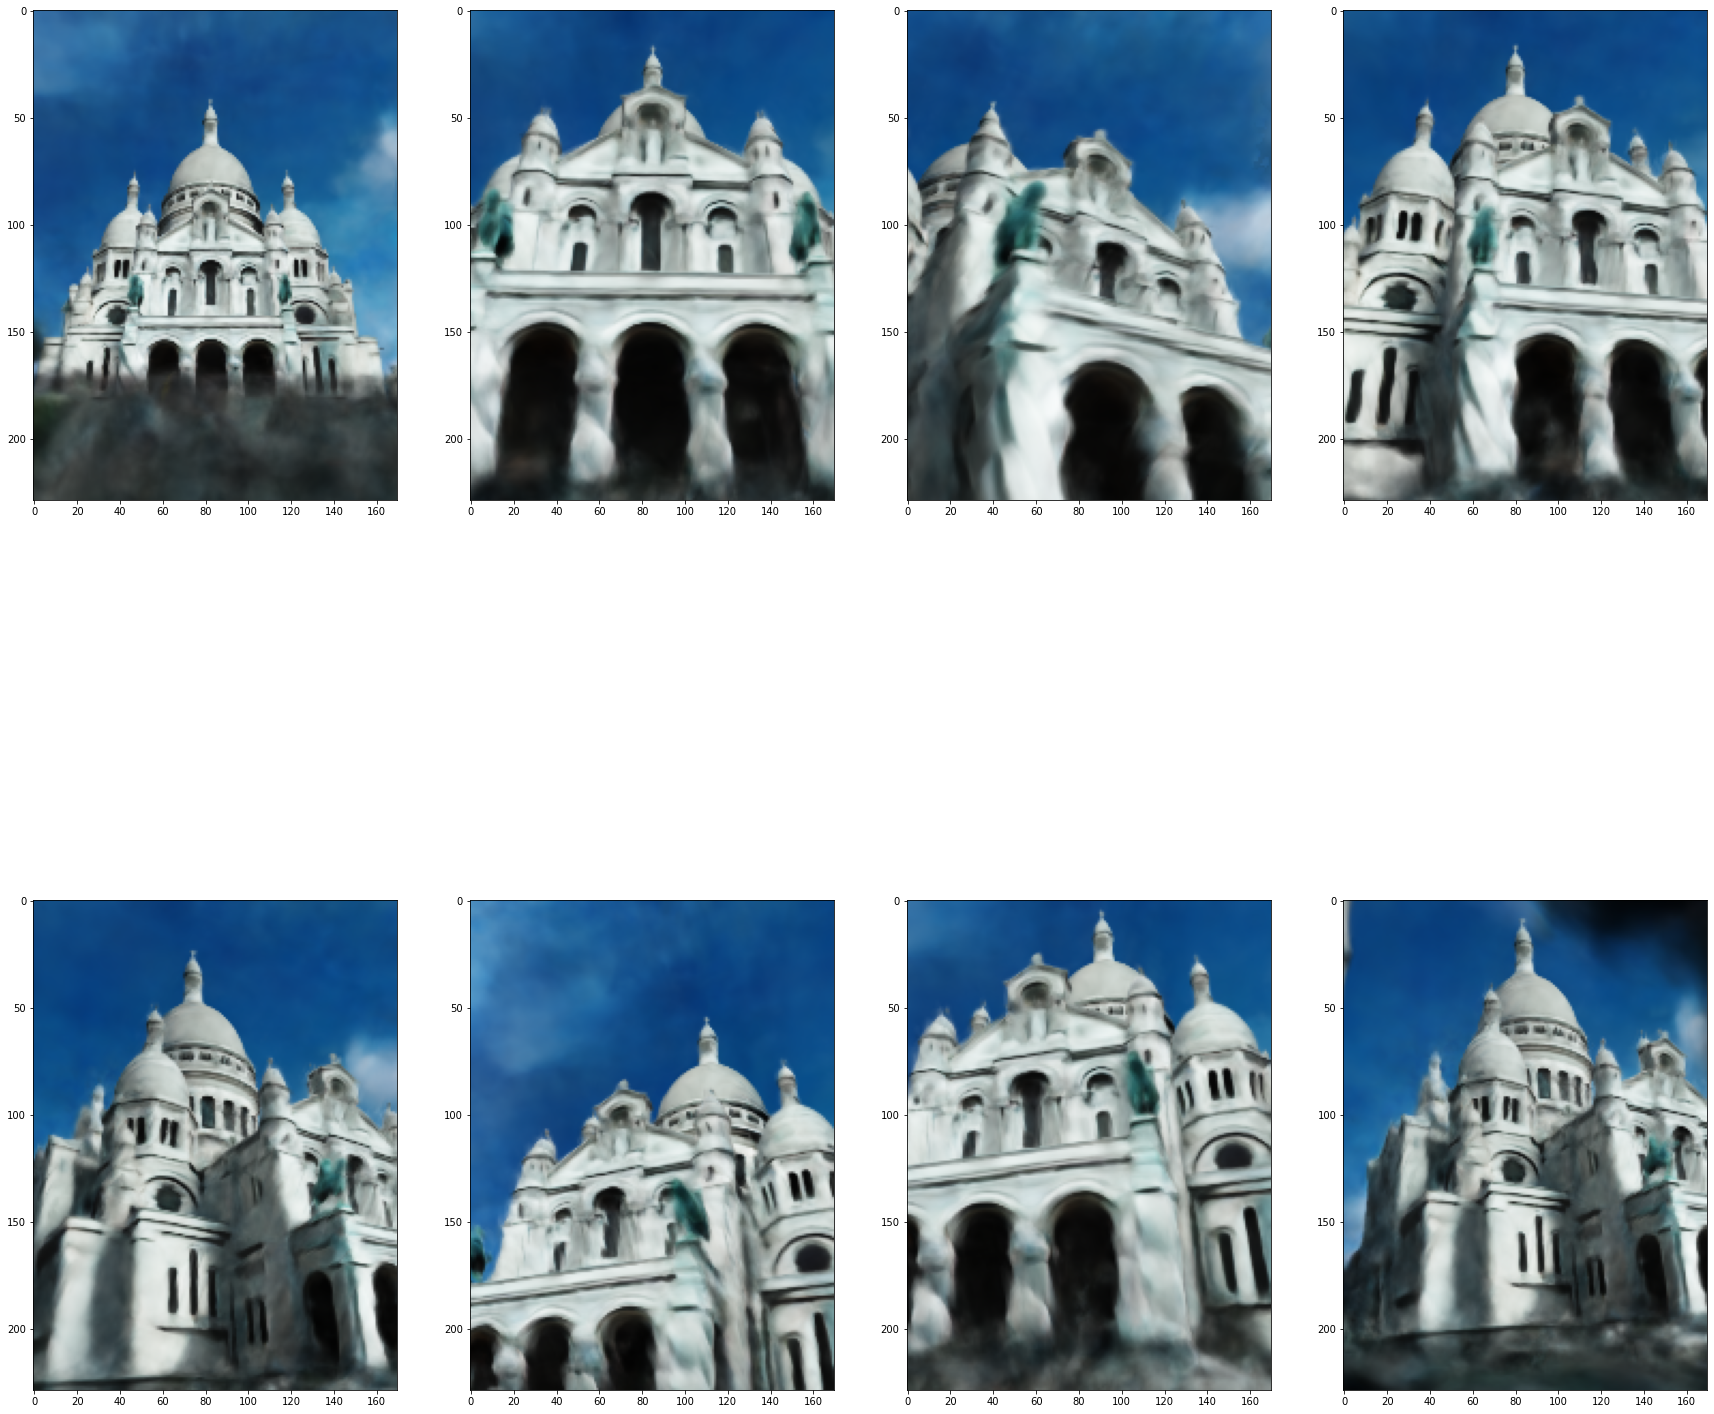

In [17]:
import matplotlib.pyplot as plt
import imageio
downsample = 2
ius = 256
views = [36, 34, 47, 77, 11, 2, 85, 95] #[5,3,9,10,12]

def rot2eul(R):
    beta = -np.arcsin(R[2,0])
    alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
    gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
    return (alpha, beta, gamma)

keyframe_pose = []
keyframe_img = []
for s in [target_index]:
    plt.figure(figsize=(30,30))
    sc = .05
    """
    if 'train' in split:
        p + 25
    if 'val' in split:
        ip + 20
    """
    img = imageio.imread(imgfiles[s])[...,:3]/255.
    c2w = posedata['c2w_mats'][s]
    kinv = posedata['kinv_mats'][s]
    c2w = np.concatenate([c2w[:3,:3], c2w[:3,3:4]*sc], -1)
    
    test_bds = posedata['bds'][s] * np.array([.9, 1.2]) * sc
    H, W = img.shape[:2]
    i, j = np.meshgrid(np.arange(0,W,downsample), np.arange(0,H,downsample), indexing='xy')
    
    test_images = img[j, i]
    test_rays = get_rays_(c2w, kinv, i, j)
    #test_images, test_rays, bds = get_example(i, downsample=1)
    test_images_flat = np.reshape(test_images, (-1,3))
    test_rays = np.reshape(test_rays, (2,-1,3))
    rng, test_params, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, ius, test_bds)
    #plt.subplot(2,4, 1)
    plt.imshow(test_images)
    
    for k, p in enumerate(views):
        sc = .05
        """
        if 'train' in split:
            p + 25
        if 'val' in split:
            ip + 20
        """
        img = imageio.imread(imgfiles[target_index-1])[...,:3]/255.
        c2w = posedata['c2w_mats'][p-1]
        kinv = posedata['kinv_mats'][target_index-1]
        c2w = np.concatenate([c2w[:3,:3], c2w[:3,3:4]*sc], -1)
        keyframe_pose.append(c2w)
        #R = c2w[:3,:3]
        #alpha, beta, gamma = rot2eul(R)
        #print(alpha, beta, gamma)
        test_bds = posedata['bds'][target_index-1] * np.array([.9, 1.2]) * sc
        H, W = img.shape[:2]
        i, j = np.meshgrid(np.arange(0,W,downsample), np.arange(0,H,downsample), indexing='xy')
    
        test_holdout_image = img[j, i]
        test_holdout_rays = get_rays_(c2w, kinv, i, j)
        
        #test_holdout_image, test_holdout_rays, test_bds = get_example(p, downsample=downsample)
        test_result = np.clip(render_fn(rng, model, test_params, None, test_holdout_rays, test_bds[0], test_bds[1], N_samples, rand=False)[0], 0, 1)
    
        plt.subplot(2,4, k+1)
        plt.imshow(test_result)
        keyframe_img.append(test_result)
    plt.show()
plt.show()


In [18]:
np.save("init_render_tour.npy", (keyframe_img, keyframe_pose))
keyframe_img, keyframe_pose = np.load("init_render_tour.npy", allow_pickle=True)
inittest_poses = keyframe_pose

/home/stella/anaconda3/envs/nerf/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [19]:
from SuperGluePretrainedNetwork.models.matching import Matching
from SuperGluePretrainedNetwork.models.utils import frame2tensor, make_matching_plot_fast, estimate_pose
import cv2
import matplotlib.cm as cm
from skimage import color
down = 1

config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': -1
    },
    'superglue': {
        'weights': 'indoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }
}
matching = Matching(device, config).eval()
keys = ['keypoints', 'scores', 'descriptors']


frame = np.array(Targetrgb.detach().cpu())
frame = color.rgb2gray(frame)
print(frame.shape)
#frame = cv2.cvtColor(target_img, cv2.COLOR_RGB2GRAY)
frame = cv2.resize(frame, dsize=(frame.shape[0]//down, frame.shape[1]//down), interpolation=cv2.INTER_AREA)
print(frame.shape)
frame_tensor = torch.from_numpy(frame[None,None]).to(device)
last_data = matching.superpoint({'image': frame_tensor})
last_data = {k+'0': last_data[k] for k in keys}
last_data['image0'] = frame_tensor
last_frame = frame
#matching = torch.nn.DataParallel(matching).to(device)

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
(337, 518)
(518, 337)


In [20]:
import time
prevtime = time.time()
valid_maxnum = 0

def rgbtogray(img_rgb):
    R = img_rgb[:,:,0]
    G = img_rgb[:,:,1]
    B = img_rgb[:,:,2]
    Y = 0.2125*R + 0.7154*G + 0.0721*B
    return Y

for ii in range(8):
    gray_keyframe = rgbtogray((keyframe_img[ii]) ).copy()
    frame_tensor = torch.from_numpy(gray_keyframe[None,None]).to(device)
    pred = matching({**last_data, 'image1': frame_tensor})
    matches = pred['matches0'][0].detach().cpu().numpy()
    valid = matches > -1
    del frame_tensor

    if valid.sum() > valid_maxnum:
        valid_maxnum = valid.sum()
        best_index = ii
        print("index: ", best_index, " / valid_feat: ", valid_maxnum)
        best_frame = gray_keyframe
        kpts0 = last_data['keypoints0'][0].detach().cpu().numpy()
        kpts1 = pred['keypoints1'][0].detach().cpu().numpy()
        confidence = pred['matching_scores0'][0].detach().cpu().numpy()
        mkpts0 = kpts0[valid]
        mkpts1 = kpts1[matches[valid]]
        mconf = confidence[valid]
        
        color = cm.jet(confidence[valid])
        text = [
            'SuperGlue',
            'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
            'Matches: {}'.format(len(mkpts0))
        ]
        k_thresh = 0.005 #matching.superpoint.config['keypoint_threshold']
        m_thresh = 0.2 #matching.superglue.config['match_threshold']
        small_text = [
            'Keypoint Threshold: {:.4f}'.format(k_thresh),
            'Match Threshold: {:.2f}'.format(m_thresh),
        ]
    del matches, pred

print(time.time()-prevtime)

index:  0  / valid_feat:  44
index:  3  / valid_feat:  90
index:  4  / valid_feat:  132
0.6160376071929932


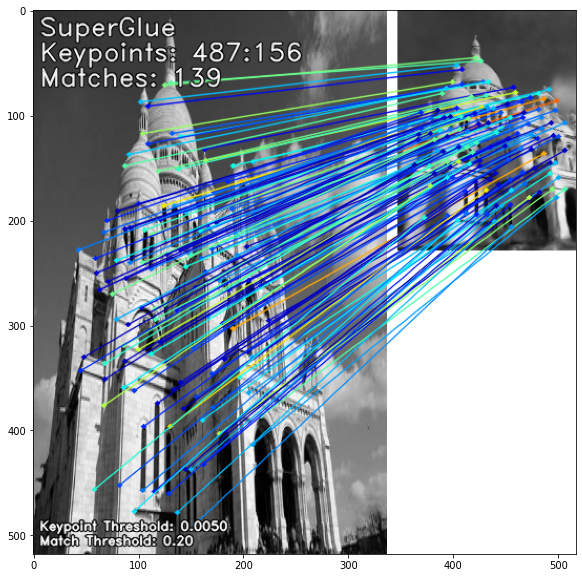

In [33]:
# Left: Target / right: reference init-view
conf_thres = 0.5
out = make_matching_plot_fast(last_frame*255., best_frame*255., kpts0, kpts1, mkpts0[mconf>conf_thres,:], mkpts1[mconf>conf_thres,:], color, text, path=None, show_keypoints=False, small_text=small_text)
fig2 = plt.figure(figsize=(10,10))
plt.imshow(out)

# iNeRF

In [21]:
import run_nerf
from tqdm import tqdm, trange
from run_nerf_helpers import *
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [22]:
best_index

4

In [23]:
initpose = torch.zeros(4,4)
initpose[:3,:] = torch.tensor(inittest_poses[best_index].astype(np.float32)).to(device)
initpose[-1,-1] = 1
initpose # 위에서 고른 best_index에 맞는 pose를 initpose로

tensor([[ 0.7990, -0.2657, -0.5394, -0.0871],
        [-0.3487, -0.9356, -0.0557,  0.0501],
        [-0.4899,  0.2326, -0.8402,  0.1215],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [24]:
#focal
target_intrinsic = posedata['kinv_mats'][target_index]
fx = 1/target_intrinsic[0,0]
fy = 1/target_intrinsic[1,1]
focal = abs(fx)

img = imageio.imread(imgfiles[target_index])[...,:3]/255.
H, W = img.shape[:2]

In [25]:
basedir = './logs'
expname = 'phototourism'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()

args = parser.parse_args('--config {}'.format(config))

# Create nerf model
render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = run_nerf.create_nerf(args)

Args:
expname = phototourism
basedir = ./logs

#ft_path = ./logs/phototourism
no_batching = True

use_viewdirs = True
white_bkgd = True
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True

Found ckpts []


In [26]:
for param in grad_vars:
    param.requires_grad = False

for param in render_kwargs_test['network_fn'].parameters():
    param.requires_grad = False

for param in render_kwargs_test['network_fine'].parameters():
    param.requires_grad = False

In [27]:
print(initpose.shape)

torch.Size([4, 4])


In [39]:
# render NeRF network at Target view 
N_rand = args.N_rand
use_batching = False #not args.no_batching
mse = torch.nn.MSELoss()

# learn_trans = torch.cat((torch.zeros(6).to(device).requires_grad_(True), torch.ones(1).to(device).requires_grad_(True))) # w(3), v(3)
learn_rot = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)
learn_trl = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)
theta = torch.ones(1).to(device).requires_grad_(True) # w(3), v(3)
learn_trans = torch.cat((learn_rot, learn_trl, theta))

def get_translated_pose(initpose, learn_trans): # 4x4, 1x6

    if 1:
        w = torch.zeros(3,3).to(learn_trans.device)
        theta = learn_trans[6]
        wnorm = 1 if torch.norm(learn_trans[0:3])==0 else torch.norm(learn_trans[0:3])
        w[0,1] = -learn_trans[2]/wnorm
        w[1,0] = learn_trans[2]/wnorm
        w[0,2] = learn_trans[1]/wnorm
        w[2,0] = -learn_trans[1]/wnorm
        w[1,2] = -learn_trans[0]/wnorm
        w[2,1] = learn_trans[0]/wnorm
        R = torch.matrix_exp(w*theta) # ^c1_c2{R}

        v = learn_trans[3:6].reshape(3,1)
        transform_pose = torch.zeros(4, 4).to(learn_trans.device)
        transform_pose[0:3,0:3] = R
        # transform_pose[0:3,-1] = theta*v.squeeze() + (1-torch.cos(theta))*torch.matmul(w,v).squeeze() + (theta-torch.sin(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        # transform_pose[0:3,-1] = v.squeeze() + (torch.sin(theta))*torch.matmul(w,v).squeeze() + (1-torch.cos(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        mat1 = (torch.eye(3) * theta) - (1 - torch.cos(theta) * w) + ((theta - torch.sin(theta)) * torch.matmul(w, w))
        mat2 = torch.matmul(mat1, v).squeeze()
        transform_pose[0:3,-1] = mat2
        transform_pose[3,3] = 1
        newpose = torch.matmul(transform_pose, initpose)
        
    if 0:
        w = torch.zeros(3,3).to(learn_trans.device)
        theta = learn_trans[6]
        wnorm = 1 if torch.norm(learn_trans[0:3])==0 else torch.norm(learn_trans[0:3])
        w[0,1] = -learn_trans[2]/wnorm
        w[1,0] = learn_trans[2]/wnorm
        w[0,2] = learn_trans[1]/wnorm
        w[2,0] = -learn_trans[1]/wnorm
        w[1,2] = -learn_trans[0]/wnorm
        w[2,1] = learn_trans[0]/wnorm
        R = torch.matrix_exp(w*theta) # ^c1_c2{R}

        v = learn_trans[3:6].reshape(3,1)
        transform_pose = torch.zeros(4, 4).to(learn_trans.device)
        transform_pose[0:3,0:3] = R
        # transform_pose[0:3,-1] = theta*v.squeeze() + (1-torch.cos(theta))*torch.matmul(w,v).squeeze() + (theta-torch.sin(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        # transform_pose[0:3,-1] = v.squeeze() + (torch.sin(theta))*torch.matmul(w,v).squeeze() + (1-torch.cos(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        transform_pose[0:3,-1] = v.squeeze()
        transform_pose[3,3] = 1
        newpose = torch.matmul(transform_pose, initpose)

    if 0:
        R = torch.zeros(3,3).to(learn_trans.device)
        R[0,1] = -learn_trans[2]
        R[1,0] = learn_trans[2]
        R[0,2] = learn_trans[1]
        R[2,0] = -learn_trans[1]
        R[1,2] = -learn_trans[0]
        R[2,1] = learn_trans[0]
        R = torch.matrix_exp(R)#*learn_trans[6]) # ^c1_c2{R}
        newpose = torch.zeros(4, 4).to(learn_trans.device)
        newpose[0:3,0:3] = torch.matmul(initpose[0:3,0:3], R) # ^w_c2{R} = ^w_c1{R} * ^c1_c2{R}
        newpose[0:3,-1] = torch.matmul(initpose[0:3,0:3], learn_trans[3:6].reshape(3,1)).squeeze() + initpose[0:3,-1] # ^w{p}_c2org = ^w{p}_c1org + ^w_c1{R} * ^c1{p}_c2org
        newpose[3,3] = 1

    if 0:
        R = torch.zeros(3,3).to(learn_trans.device)
        R[0,1] = -learn_trans[2]
        R[1,0] = learn_trans[2]
        R[0,2] = learn_trans[1]
        R[2,0] = -learn_trans[1]
        R[1,2] = -learn_trans[0]
        R[2,1] = learn_trans[0]
        R = torch.matrix_exp(R) # ^c1_c2{R}
        newpose = torch.zeros(4, 4).to(learn_trans.device)
        newpose[0:3,0:3] = torch.matmul(R, initpose[0:3,0:3])#
        newpose[0:3,-1] = torch.matmul(R, initpose[0:3,-1].reshape(3,1)).squeeze() + learn_trans[3:6] #
        newpose[3,3] = 1

    return newpose

with torch.no_grad():
    print("init: \n", initpose)
    newpose = get_translated_pose(initpose, learn_trans)
    print(newpose)
    print(torch.equal(newpose, initpose))

init: 
 tensor([[ 0.7990, -0.2657, -0.5394, -0.0871],
        [-0.3487, -0.9356, -0.0557,  0.0501],
        [-0.4899,  0.2326, -0.8402,  0.1215],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.7990, -0.2657, -0.5394, -0.0871],
        [-0.3487, -0.9356, -0.0557,  0.0501],
        [-0.4899,  0.2326, -0.8402,  0.1215],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
True


In [29]:
import jax.numpy as jnp

def render_rays2(rnd_input, model, params, bvals, rays, near, far, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays

    # Compute 3D query points
    z_vals = jnp.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = jnp.reshape(pts, [-1,3])
    if bvals is not None:
        pts_flat = jnp.concatenate([np.sin(pts_flat @ bvals.T), 
                                jnp.cos(pts_flat @ bvals.T)], axis=-1)
        
    raw = model.apply(params, pts_flat)
    raw = jnp.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = jnp.concatenate([z_vals[..., 1:] - z_vals[..., :-1], jnp.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1. - jnp.exp(-sigma_a * dists)
    trans = jnp.minimum(1., 1. - alpha + 1e-10)
    trans = jnp.concatenate([jnp.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha *jnp.cumprod(trans, -1)
    
    rgb_map = jnp.sum(weights[...,None] * rgb, -2) 
    acc_map = jnp.sum(weights, -1)
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = jnp.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner2(rnd_input, model, params, bvals, rays, near, far, rand, allret, N_samples):
    return render_rays2(rnd_input, model, params, bvals, rays, near, far, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 7, 8, 9))

def render_fn2(rnd_input, model, params, bvals, rays, near, far, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner2(rnd_input, model, params, bvals, rays[:,i:i+chunk], near, far, rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [jnp.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [47]:
def get_rays__(c2w, kinv, i, j):
#     i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    pixco = jnp.stack([i, j, jnp.ones_like(i)], -1)
    dirs = pixco @ kinv.T
#     dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = jnp.sum(dirs[..., jnp.newaxis, :] * c2w[:3,:3], -1)
    rays_o = jnp.broadcast_to(c2w[:3,-1], rays_d.shape)
    return jnp.stack([rays_o, rays_d], 0)

Using 4 GPU(s).
tensor([[ 0.7990, -0.2657, -0.5394, -0.0871],
        [-0.3487, -0.9356, -0.0557,  0.0501],
        [-0.4899,  0.2326, -0.8402,  0.1215],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.7527, -0.2756, -0.5979, -1.5260],
        [-0.3638, -0.9310, -0.0289,  1.0162],
        [-0.5487,  0.2392, -0.8011,  2.4435],
        [ 0.0000, -0.0000, -0.0000,  1.0000]])


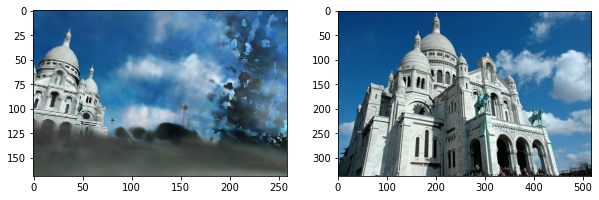

In [32]:

args.n_gpus = torch.cuda.device_count()
print(f"Using {args.n_gpus} GPU(s).")

print(initpose)
print(Targetpose)
Targetkinv = posedata['kinv_mats'][target_index]
sc = .05

with torch.no_grad():
    fig = plt.figure(figsize=(10,30))
    axes = fig.subplots(nrows=1, ncols=2)
    
    #rgb1, disp, _, _ = run_nerf.render(H//4, W//4, (focal)/4, c2w=initpose[:3, :4], **render_kwargs_test)
    img = imageio.imread(imgfiles[target_index])[...,:3]/255.
    c2w = initpose[:3, :4].detach().cpu()
    c2w = jnp.array(c2w, dtype=jnp.float32)
    kinv = Targetkinv
    c2w = jnp.concatenate([c2w[:3,:3], c2w[:3,3:4]*sc], -1)
    #R = c2w[:3,:3]
    #alpha, beta, gamma = rot2eul(R)
    #print(alpha, beta, gamma)
    test_bds = posedata['bds'][target_index] * jnp.array([.9, 1.2]) * sc
    H, W = img.shape[:2]
    ii, jj  = jnp.meshgrid(jnp.arange(0,W,downsample), jnp.arange(0,H,downsample), indexing='xy')
    
    test_holdout_image = img[jj, ii]
    test_holdout_rays = get_rays_(c2w, kinv, ii, jj)
        
    #test_holdout_image, test_holdout_rays, test_bds = get_example(p, downsample=downsample)
    rgb1 = jnp.clip(render_fn2(rng, model, test_params, None, test_holdout_rays, test_bds[0], test_bds[1], N_samples, rand=False)[0], 0, 1)
    axes[0].imshow(jnp.clip(rgb1, 0., 1.))
    axes[1].imshow(jnp.clip(Targetrgb.detach().cpu().numpy(), 0., 1.))

In [33]:

# feature를 sampling하는 위치로
conf_thres = 0.6
Hidx, Widx = torch.from_numpy(mkpts0[mconf>conf_thres,0].astype(np.long)), torch.from_numpy(mkpts0[mconf>conf_thres,1].astype(np.long))

# interesting region - 
oHidx, oWidx = Hidx, Widx
for i in [-1,0,1]:
    for j in [-1,0,1]:
        if i==0 and j==0:
            continue
        oHidx, oWidx = torch.cat((oHidx, Hidx+i)), torch.cat((oWidx, Widx+j))

/home/stella/anaconda3/envs/nerf/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
print(Targetpose.dtype)

torch.float32


In [97]:
import time
N_iters = 100
step = 100
sampledown = 16 #16 # only for video generation
sN = 1024*6 
# optim = torch.optim.Adam(params=[learn_trans], lr=1e-2, betas=(0.9, 0.999))
optim = torch.optim.Adam([{'params':learn_trl ,'lr':1e-2}, {'params':learn_rot ,'lr':5e-2}, {'params':theta ,'lr':1e-2}], betas=(0.9, 0.999))
# optim_rot = torch.optim.Adam(params=[learn_trl], lr=1e-1, betas=(0.9, 0.999))
opt_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.998)
posesave = []
losssave = []
renderpath = "./Photo_Metainerf_updateruletest"
os.makedirs(renderpath, exist_ok=True)
bestidx = []
saved_time = []
saved_loss = []
# curr_trans = learn_trans*0.001

for test in range(10):
    t_start = time.time()
    for i in trange(N_iters):
        optim.zero_grad()
        learn_trans = torch.cat((learn_rot, learn_trl, theta))
        newpose = get_translated_pose(initpose, learn_trans)
        
        if 1:#i==0:
            #Hidx, Widx = torch.from_numpy(np.random.choice(np.arange(H//down), size=sN)).to(device), torch.from_numpy(np.random.choice(np.arange(W//down), size=sN)).to(device)
            # Hidx, Widx = torch.from_numpy(mkpts0[:,0].astype(np.long)), torch.from_numpy(mkpts0[:,1].astype(np.long))
            Hidx, Widx = oHidx, oWidx
            H2, W2 = Targetrgb.shape[:2]
            iii, jjj  = jnp.meshgrid(jnp.arange(0,W2,sampledown), jnp.arange(0,H2,sampledown), indexing='xy')
            Targetrgb_new = (Targetrgb).detach().cpu().numpy()[jjj, iii]
            Targetrgb_new = torch.from_numpy(Targetrgb_new).to(device).requires_grad_(True)
        else:
            with torch.no_grad():
                bestidx = torch.argsort(torch.sum((rgbest-Targetrgb_new[Hidx, Widx, 0:3])**2, dim=-1), descending=True).to(device)
            newHidx, newWidx = torch.from_numpy(np.random.choice(np.arange(H//down), size=sN-sN//2)).to(device), torch.from_numpy(np.random.choice(np.arange(W//down), size=sN-sN//2)).to(device)
            Hidx, Widx = torch.cat((Hidx[bestidx[:sN//2]], newHidx), dim=0), torch.cat((Widx[bestidx[:sN//2]], newWidx), dim=0)
            # with torch.no_grad():
            #     rgb_sample, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=newpose[:3, :4], **render_kwargs_test)
            #     est_mask = rgb_sample[:,:,0] < 1.0
            #     Hidx, Widx = torch.tensor(np.random.choice(np.arange(H//sampledown), size=sN*5)).to(est_mask.device), torch.tensor(np.random.choice(np.arange(W//sampledown), size=sN*5)).to(est_mask.device)
            #     Hidx, Widx = Hidx[est_mask[Hidx, Widx]][:sN], Widx[est_mask[Hidx, Widx]][:sN]
            #     Hidx, Widx = Hidx*sampledown + torch.randint_like(Hidx, high=3), Widx*sampledown + torch.randint_like(Widx, high=3)
        img = imageio.imread(imgfiles[target_index])[...,:3]/255.
        c2w = newpose[:3, :4].detach().cpu()
        c2w = jnp.array(c2w, dtype=jnp.float32)
        kinv = Targetkinv
        c2w = jnp.concatenate([c2w[:3,:3], c2w[:3,3:4]*sc], -1)

        test_bds = posedata['bds'][target_index] * jnp.array([.9, 1.2]) * sc
        H, W = img.shape[:2]
        ii, jj  = jnp.meshgrid(jnp.arange(0,W,sampledown), jnp.arange(0,H,sampledown), indexing='xy')
        test_holdout_image = img[jj, ii]
        test_holdout_rays = get_rays__(c2w, kinv, ii, jj)
        
        #test_holdout_image, test_holdout_rays, test_bds = get_example(p, downsample=downsample)
        rgbest = jnp.clip(render_fn2(rng, model, test_params, None, test_holdout_rays, test_bds[0], test_bds[1], N_samples, rand=False)[0], 0, 1)
    
        #rgbest, disp, _, _ = run_nerf.render(H//down, W//down, focal/down, c2w=newpose[:3, :4], **render_kwargs_test, chunk=sN, Hidx=Hidx, Widx=Widx)
        # valid_idx = torch.sum(rgbest[:,0]==1)
        # loss = mse(rgbest[valid_idx], Targetrgb[Hidx[valid_idx], Widx[valid_idx], 0:3])
        #rgbest = jnp.reshape(rgbest,(-1,3))
        #print(rgbest.shape)
        #print(Targetrgb.shape)
        #print(Targetrgb[Hidx//sampledown, Widx//sampledown, 0:3].shape)
        np_array = np.asarray(rgbest)
        rgbest = torch.from_numpy(np_array).cuda().requires_grad_(True)
        loss = mse(rgbest, Targetrgb_new)
        print(loss)
        loss.backward()
        optim.step()
        opt_scheduler.step()

        posesave.append(newpose.detach())
        losssave.append(torch.mean((rgbest.detach()-Targetrgb_new)**2))
        if i%(N_iters/step)==0:
            with torch.no_grad():
                rgb_sample = jnp.clip(render_fn2(rng, model, test_params, None, test_holdout_rays, test_bds[0], test_bds[1], N_samples, rand=False)[0], 0, 1)
                #rgb_sample, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=newpose[:3, :4], **render_kwargs_test)
                """
                plt.imsave(os.path.join(renderpath, str(i)+".jpg"), np.clip(rgb_sample.detach().cpu().numpy(),  0.0, 1.0))
                """
                # plt.imshow(np.clip(rgb_sample.detach().cpu().numpy(),  0.0, 1.0))

        if i==9:
            assert not torch.equal(learn_trans[0:3], torch.zeros(3))
            assert not torch.equal(learn_trans[3:6], torch.zeros(3))

    # posesave 
    t_end = time.time()
    passed_time = t_end - t_start
    print(passed_time)

    saved_time.append(passed_time)
    save_loss = losssave[-1]
    saved_loss.append(save_loss)
    
"""
torch.save({"posesave": torch.stack(posesave), 
            "losssave": torch.stack(losssave)
            }, os.path.join(renderpath,"pose_loss_save.pt"))
"""
#01:24

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  3%|▎         | 3/100 [00:02<01:12,  1.34it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  4%|▍         | 4/100 [00:02<01:10,  1.36it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  5%|▌         | 5/100 [00:03<01:09,  1.36it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  6%|▌         | 6/100 [00:04<01:09,  1.35it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  7%|▋         | 7/100 [00:05<01:07,  1.37it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  8%|▊         | 8/100 [00:05<01:06,  1.38it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  9%|▉         | 9/100 [00:06<01:06,  1.38it/s]

tensor(0.0915, grad_fn=<MseLossBackward>)


  9%|▉         | 9/100 [00:07<01:14,  1.22it/s]


AssertionError: 